In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
def preprocessing_data(data, dict_grade=None,dict_sub_grade=None, dict_emp_title=None, dict_pymnt_plan=None, dict_purpose=None):
    numeric_data = data.drop(['record_id', 'earliest_cr_line', 'issue_d', 'addr_state', 'zip_code'], axis=1)
    
    numeric_data['term'] = numeric_data['term'].map({' 36 months': 0, ' 60 months': 1})
    numeric_data['application_type'] = numeric_data['application_type'].map({'INDIVIDUAL': 0, 'JOINT': 1})
    numeric_data['initial_list_status'] = numeric_data['initial_list_status'].map({'f': 0, 'w': 1})
    numeric_data['emp_length'] = numeric_data['emp_length'].map({'< 1 year': 1, '1 year': 2, '2 years': 3,  '3 years': 4,  '4 years': 5,  '5 years': 6,  '6 years': 7,  '7 years': 8,  '8 years': 9,  '9 years': 10,  '10+ years': 11})

#     numeric_data['addr_state'] = pd.factorize(numeric_data['addr_state'])[0]
    numeric_data['emp_length'].fillna(0, inplace=True)
    numeric_data['emp_title'].fillna('0', inplace=True)
    numeric_data['mths_since_last_delinq'].fillna(numeric_data['mths_since_last_delinq'].notnull().min(), inplace=True)
    numeric_data['collections_12_mths_ex_med'].fillna(numeric_data['collections_12_mths_ex_med'].notnull().max(), inplace=True)
    numeric_data['revol_util'].fillna(numeric_data['revol_util'].notnull().mean(), inplace=True)
    numeric_data['tot_coll_amt'].fillna(numeric_data['tot_coll_amt'].notnull().min(), inplace=True)
    numeric_data['tot_cur_bal'].fillna(numeric_data['tot_cur_bal'].notnull().min(), inplace=True)
    numeric_data['total_rev_hi_lim'].fillna(numeric_data['total_rev_hi_lim'].notnull().min(), inplace=True)

    
    ohe = OneHotEncoder()
    new_ohe_features = ohe.fit(numeric_data.home_ownership.values.reshape(-1, 1))
    data['home_ownership_ohe'] = ohe.transform(numeric_data.home_ownership.values.reshape(-1, 1))
#     print(ohe.get_feature_names())
    new_ohe_features = ohe.fit(numeric_data.verification_status.values.reshape(-1, 1))
    data['verification_ohe'] = ohe.transform(numeric_data.verification_status.values.reshape(-1, 1))
    
    le = LabelEncoder()

    if dict_grade is None:
        le.fit(numeric_data.grade.astype(str))
        numeric_data['grade_le'] = le.transform((numeric_data['grade'].values))
        dict_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['grade_le'] = numeric_data['grade'].map(dict_grade).fillna(-1)  

    if dict_sub_grade is None:
        le.fit(numeric_data.sub_grade.astype(str))
        numeric_data['sub_grade_le'] = le.transform(numeric_data['sub_grade'].values)
        dict_sub_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['sub_grade_le'] = numeric_data['sub_grade'].map(dict_sub_grade).fillna(-1)  
    
    if dict_emp_title is None:
        le.fit(numeric_data.emp_title.astype(str))
        numeric_data['emp_title_le'] = le.transform(numeric_data['emp_title'].values)
        dict_emp_title = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['emp_title_le'] = numeric_data['emp_title'].map(dict_emp_title).fillna(-1)        

    if dict_pymnt_plan is None:
        le.fit(numeric_data.pymnt_plan.astype(str))
        numeric_data['pymnt_plan_le'] = le.transform(numeric_data['pymnt_plan'].values)
        dict_pymnt_plan = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        numeric_data['pymnt_plan_le'] = numeric_data['pymnt_plan'].map(dict_pymnt_plan).fillna(0)  
    
    if dict_purpose is None:
        le.fit(numeric_data.purpose.astype(str))
        numeric_data['purpose_le'] = le.transform(numeric_data['purpose'].values)
        dict_purpose = dict(zip(le.classes_, le.transform(le.classes_)))
#         dict_purpose[None] = 5
    else:
        numeric_data['purpose_le'] = numeric_data['purpose'].map(dict_purpose).fillna(-1) 
#     print(dict_grade)

    numeric_data = numeric_data.drop(['grade', 'sub_grade', 'purpose', 'emp_title', 'pymnt_plan', 'home_ownership', 'verification_status'], axis=1)
    
    return numeric_data, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose

    #     numeric_data['zip_code'] = (numeric_data['zip_code'].str[:3])

In [4]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [5]:
train, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose = preprocessing_data(train)
test = preprocessing_data(test, dict_grade, dict_sub_grade, dict_emp_title, dict_pymnt_plan, dict_purpose)[0]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [6]:
X_train = train.drop(['loan_status'], axis=1)
y_train = train['loan_status']

X_test = test.drop(['loan_status'], axis=1)
y_test = test['loan_status']

X_train = scale(X_train)
X_test = scale(X_test)

ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
# print(len(y_train))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int32, int64, float64, object were all converted to float64 by the scale function.
  import sys
C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by the scale function.
  


In [7]:
model_l1 = LogisticRegression(penalty='l1', random_state=42)
model_l1.fit(X_train, y_train)
preds = model_l1.predict(X_test)

print('l1: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l1: 
Accuracy score: 0.6539953710641557
Recall score: 0.6579746077886547
Precision score: 0.8656431021877284
Auc score: 0.6489707263945159


In [8]:
model_l2 = LogisticRegression(penalty='l2', random_state=42)
model_l2.fit(X_train, y_train)
preds = model_l2.predict(X_test)

print('l2: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


l2: 
Accuracy score: 0.6540453236092378
Recall score: 0.6579959817039285
Precision score: 0.8656955653665532
Auc score: 0.6490567656240236


In [128]:
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [3, 5]),
    'n_estimators': hp.choice('n_estimators', [100, 200, 500]),
#     'criterion': hp.choice('criterion', ["entropy","gini"])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                           
0.6554213702291357                                  
{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 200}
 10%|█         | 1/10 [02:15<20:17, 135.23s/it, best loss: -0.6554213702291357]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6554213702291357                                                             
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}                   
 20%|██        | 2/10 [02:52<14:05, 105.71s/it, best loss: -0.6554213702291357]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6556785492216448                                                             
{'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 500}                   
 30%|███       | 3/10 [08:21<20:09, 172.83s/it, best loss: -0.6556785492216448]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 500}                   
 40%|████      | 4/10 [15:08<24:19, 243.20s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}                   
 50%|█████     | 5/10 [16:50<16:44, 200.84s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 100}                   
 60%|██████    | 6/10 [18:12<11:00, 165.19s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 200}                   
 70%|███████   | 7/10 [20:54<08:12, 164.14s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}                   
 80%|████████  | 8/10 [21:30<04:11, 125.81s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 500}                   
 90%|█████████ | 9/10 [26:58<03:06, 186.22s/it, best loss: -0.6696808438745588]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                      
0.6696808438745588                                                             
{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}                   
100%|██████████| 10/10 [28:41<00:00, 161.26s/it, best loss: -0.6696808438745588]
best:
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 2}


In [9]:
forest_tree = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, max_depth=9, n_jobs=-1, random_state=42)

forest_tree.fit(X_train, y_train)
preds = forest_tree.predict(X_test)

print('Forest: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

Forest: 
Accuracy score: 0.6462360757280583
Recall score: 0.6431838584191852
Precision score: 0.8686063964900127
Auc score: 0.6500901584312037


In [16]:
def acc_model(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [3, 5])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                           
0.6388059630862529                                  
{'max_depth': 5, 'min_samples_leaf': 5}             
 10%|█         | 1/10 [00:03<00:30,  3.39s/it, best loss: -0.6388059630862529]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6388059630862529                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 20%|██        | 2/10 [00:06<00:27,  3.39s/it, best loss: -0.6388059630862529]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.648468426571989                                                             
{'max_depth': 7, 'min_samples_leaf': 3}                                       
 30%|███       | 3/10 [00:11<00:26,  3.75s/it, best loss: -0.648468426571989] 

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                    
0.648468426571989                                                            
{'max_depth': 7, 'min_samples_leaf': 5}                                      
 40%|████      | 4/10 [00:15<00:23,  3.97s/it, best loss: -0.648468426571989]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                    
0.6562480117211505                                                           
{'max_depth': 9, 'min_samples_leaf': 5}                                      
 50%|█████     | 5/10 [00:21<00:22,  4.43s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 60%|██████    | 6/10 [00:24<00:16,  4.11s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 3}                                       
 70%|███████   | 7/10 [00:28<00:11,  3.91s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 5, 'min_samples_leaf': 5}                                       
 80%|████████  | 8/10 [00:31<00:07,  3.75s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 3, 'min_samples_leaf': 3}                                       
 90%|█████████ | 9/10 [00:33<00:03,  3.33s/it, best loss: -0.6562480117211505]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



new best:                                                                     
0.6562480117211505                                                            
{'max_depth': 3, 'min_samples_leaf': 3}                                       
100%|██████████| 10/10 [00:36<00:00,  3.01s/it, best loss: -0.6562480117211505]
best:
{'max_depth': 3, 'min_samples_leaf': 1}


In [11]:
reg_tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, random_state=42)

reg_tree.fit(X_train, y_train)
preds = reg_tree.predict(X_test)

print('Tree: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

Tree: 
Accuracy score: 0.6497327538838104
Recall score: 0.6618860342837601
Precision score: 0.8558202520451028
Auc score: 0.6343866159663847


In [ ]:
def acc_model(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'n_neighbors': hp.choice('n_neighbors', [3, 5, 7])
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=3, trials=trials)
print ('best:')
print (best)

  0%|          | 0/3 [00:00<?, ?it/s, best loss: ?]

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



In [23]:
import xgboost as xgb


xg_reg = xgb.XGBClassifier(max_depth = 4, n_estimators = 30)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

print('XGB: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

XGB: 
Accuracy score: 0.6417070449739414
Recall score: 0.6365579446843073
Precision score: 0.8683811523209704
Auc score: 0.6482088947293136


Forest: 


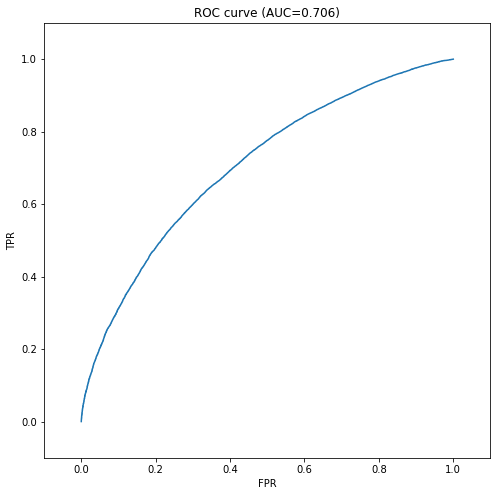

Tree: 


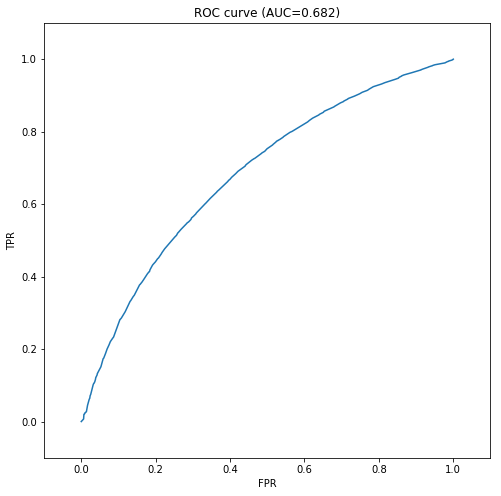

L1: 


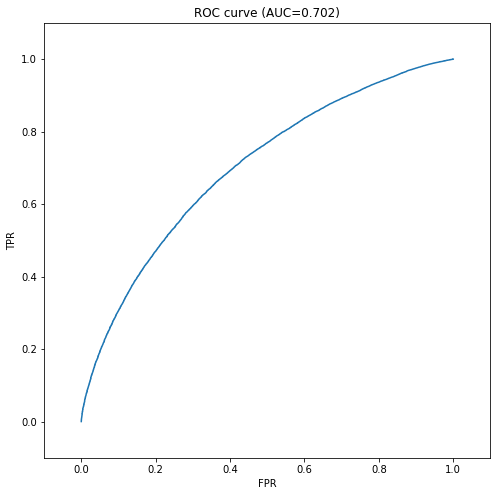

L2: 


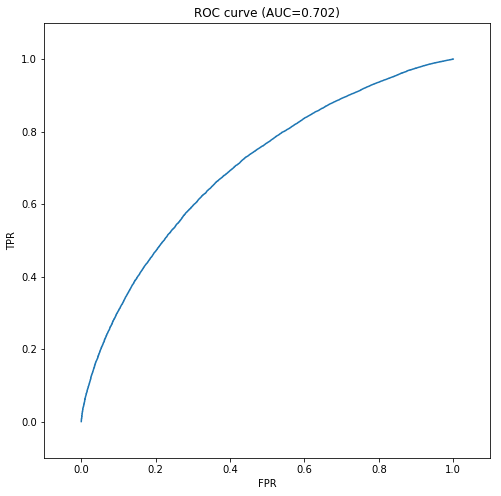

XGB: 


In [ ]:
def calculate_score_on_dataset_and_show_graph(X_test, y_test, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
#     pl.style.use('ggplot')
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    pl.figure(figsize=(8, 8,))
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(auc))
    pl.show()
    
    return auc
print('Forest: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, forest_tree)
print('Tree: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, reg_tree)
print('L1: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, model_l1)
print('L2: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, model_l2)
print('XGB: ')
calculate_score_on_dataset_and_show_graph(X_test, y_test, xg_reg)

In [18]:
import operator 


def getNeighbors(X_train, y_train, X_test, k):
    distances = []
    length = len(X_test) 
    neighbors = []
    i = 0
    for x in X_train:
        distance = np.linalg.norm(X_test - x)
        distances.append((y_train[i], distance))
        i += 1
    distances.sort(key=operator.itemgetter(1))
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [19]:
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key = operator.itemgetter(1), reverse=True)
    return sortedVotes

In [ ]:
predictions = []
k = 3
X = numeric_data.drop(['loan_status', 'verification_status', 'zip_code', 'grade_le', 'sub_grade_le', 'emp_title_le', 'purpose_le'], axis=1)
y = numeric_data['loan_status']
X = scale(X)

ros = RandomUnderSampler(random_state=0)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(len(X_test))

i = 0
for x in X_test:
    neighbors = getNeighbors(X_train, y_train, x, k)
    if neighbors is not None:
        result = getResponse(neighbors)
        predictions.append(result[0][0])
#         print('predicted: ' + str(result))
#         print('actual: ' + str(y_test[i]))
#         print(len(predictions))
        i += 1
print('Own Knn: ')

print('Recall score: ' + str(metrics.recall_score(y_test, predictions)))

print('Precision score: ' + str(metrics.precision_score(y_test, predictions)))

print('Auc score: ' + str(metrics.roc_auc_score(y_test, predictions)))